In [1]:
import random
import os
import numpy as np
import torch
from torchvision.transforms.functional import to_tensor, normalize, affine
from PIL import Image
from typing import Tuple, List, NamedTuple
from tqdm import tqdm
import zipfile
from urllib import request

import matplotlib.pyplot as plt

In [2]:
# Seed all random number generators
np.random.seed(197331)
torch.manual_seed(197331)
random.seed(197331)

In [3]:
class NetworkConfiguration(NamedTuple):
    n_channels: Tuple[int, ...] = (16, 32, 48)
    kernel_sizes: Tuple[int, ...] = (3, 3, 3)
    strides: Tuple[int, ...] = (1, 1, 1)
    dense_hiddens: Tuple[int, ...] = (128, 128) #CHANGED

In [4]:
device = torch.device('cpu')

In [5]:
class Trainer:
    def __init__(self,
                 network_type: str = "mlp",
                 net_config: NetworkConfiguration = NetworkConfiguration(),
                 lr: float = 0.001,
                 batch_size: int = 128,
                 activation_name: str = "relu"):
        
        self.train, self.test = self.load_dataset()
        self.network_type = network_type
        activation_function = self.create_activation_function(activation_name)
        input_dim = self.train[0].shape[1:]
        if network_type == "mlp":
            self.network = self.create_mlp(input_dim[0]*input_dim[1]*input_dim[2], 
                                           net_config,
                                           activation_function)
        elif network_type == "cnn":
            self.network = self.create_cnn(input_dim[0], 
                                           net_config, 
                                           activation_function)
        else:
            raise ValueError("Network type not supported")
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
        self.lr = lr
        self.batch_size = batch_size

        self.train_logs = {'train_loss': [], 'test_loss': [],
                           'train_mae': [], 'test_mae': []}

    def mnist_random_example(self):
        X, y = self.train
        idx = np.random.randint(X.shape[0])
        exp = X[idx].reshape(X.shape[2],X.shape[3])
        # print("The number in the image below is:", y_train[idx])
        plt.imshow(exp)

    @staticmethod
    def load_dataset() -> Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        if not os.path.exists('./rotated_fashion_mnist'):
            url = 'https://drive.google.com/u/0/uc?id=1NQPmr01eIafQKeH9C9HR0lGuB5z6mhGb&export=download&confirm=t&uuid=645ff20a-d47b-49f0-ac8b-4a7347529c8e&at=AHV7M3d_Da0D7wowJlTzzZxDky5c:1669325231545'
            with request.urlopen(url) as f:
                with open('./rotated_fashion_mnist.zip', 'wb') as out:
                    out.write(f.read())
            with zipfile.ZipFile('./rotated_fashion_mnist.zip', 'r') as zip_ref:
                zip_ref.extractall()
            os.remove('./rotated_fashion_mnist.zip')
            
        datapath = './rotated_fashion_mnist'

        def get_paths_and_rots(split: str) -> List[Tuple[str, float]]:
            image_paths, rots = [], []
            files = os.listdir(os.path.join(datapath, split))
            for file in files:
                image_paths.append(os.path.join(datapath, split, file))
                rots.append(float(file.split('_')[1].split('.')[0]))
            return image_paths, rots
        
        def to_tensors(image_paths: List[str], rots: List[float]) -> Tuple[torch.Tensor, torch.Tensor]:
            images = [normalize(to_tensor(Image.open(path)), (0.5,), (0.5,)) 
                      for path in image_paths]
            images = torch.stack(images)
            labels = torch.tensor(rots).view(-1, 1)
            return images, labels

        X_train, y_train = to_tensors(*get_paths_and_rots('train'))
        X_test, y_test = to_tensors(*get_paths_and_rots('test'))
        
        # Normalize y for easier training
        mean, std = y_train.mean(), y_train.std()
        y_train = (y_train - mean) / std
        y_test = (y_test - mean) / std
        
        return (X_train, y_train), (X_test, y_test)

    @staticmethod
    def create_mlp(input_dim: int, net_config: NetworkConfiguration,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a multi-layer perceptron (MLP) network.

        :param net_config: a NetworkConfiguration named tuple. Only the field 'dense_hiddens' will be used.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the MLP.
        """
        hidden_sizes = net_config.dense_hiddens
        
        layers = [torch.nn.Flatten(),torch.nn.Linear(input_dim, hidden_sizes[0]), activation ]
        
        for i in range(1, len(hidden_sizes)):
            layers += [ torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]), activation]

        layers += [ torch.nn.Linear(hidden_sizes[-1], 1) ]
        
        return torch.nn.Sequential(*layers)

    @staticmethod
    def create_cnn(in_channels: int, net_config: NetworkConfiguration,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a convolutional network.

        :param in_channels: The number of channels in the input image.
        :param net_config: a NetworkConfiguration specifying the architecture of the CNN.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the CNN.
        """
        n_channels, kernel_sizes, strides, dense_hiddens = net_config
        
        layers = [ torch.nn.Conv2d(in_channels, n_channels[0], kernel_size=kernel_sizes[0], stride=strides[0]), activation ]
        
        for i in range(1, len(n_channels)):
            layers += [ torch.nn.Conv2d(n_channels[i-1], n_channels[i], kernel_size=kernel_sizes[i], stride=strides[i]),
                       activation]
            if i!= len(n_channels):
                layers += [ torch.nn.MaxPool2d(kernel_size=2) ]

        layers += [ torch.nn.AdaptiveMaxPool2d((4, 4)), torch.nn.Flatten() ]
        
        layers += [ torch.nn.Linear(n_channels[-1]*4*4, dense_hiddens[0]), activation ]
        
        for i in range(1, len(dense_hiddens)):
          layers += [ torch.nn.Linear(dense_hiddens[i-1], dense_hiddens[i]), activation ]

        layers += [ torch.nn.Linear(dense_hiddens[-1], 1) ]
        
        return torch.nn.Sequential(*layers)

    @staticmethod
    def create_activation_function(activation_str: str) -> torch.nn.Module:
        if activation_str == "relu" :
            return torch.nn.ReLU()
        if activation_str == "tanh" :
            return torch.nn.Tanh()
        else:
            return torch.nn.Sigmoid()

    def compute_loss_and_mae(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    
        preds = self.network(X)
        
        # MAE (Mean absolute error)
        loss_mae = torch.nn.L1Loss()
        ouput_mae = loss_mae(preds, y)
        
        # MSE (Mean squared error)
        loss_mse = torch.nn.MSELoss()
        ouput_mse = loss_mse(preds, y)

        return (ouput_mse,ouput_mae)

    def training_step(self, X_batch: torch.Tensor, y_batch: torch.Tensor):
        mse,_ = self.compute_loss_and_mae(X_batch, y_batch)
        self.optimizer.zero_grad()
        mse.backward()
        self.optimizer.step()

    def log_metrics(self, X_train: torch.Tensor, y_train: torch.Tensor,
                    X_test: torch.Tensor, y_test: torch.Tensor) -> None:
        self.network.eval()
        with torch.inference_mode():
            train_loss, train_mae = self.compute_loss_and_mae(X_train, y_train)
            test_loss, test_mae = self.compute_loss_and_mae(X_test, y_test)
        self.train_logs['train_mae'].append(train_mae.item())
        self.train_logs['test_mae'].append(test_mae.item())
        self.train_logs['train_loss'].append(train_loss.item())
        self.train_logs['test_loss'].append(test_loss.item())

    def train_loop(self, n_epochs: int):
        # Prepare train and validation data
        X_train, y_train = self.train
        X_test, y_test = self.test

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))
        self.log_metrics(X_train[:2000], y_train[:2000], X_test, y_test)
        for epoch in tqdm(range(n_epochs)):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                self.training_step(minibatchX, minibatchY)
            self.log_metrics(X_train[:2000], y_train[:2000], X_test, y_test)
        return self.train_logs

    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mse,mae = self.compute_loss_and_mae(X, y)
        
        return torch.mean(mse), torch.mean(mae)

    def test_equivariance(self):
        from functools import partial
        test_im = (self.train[0][0] + 1) / 2
        conv = torch.nn.Conv2d(kernel_size=3, in_channels=1, out_channels=1, stride=1, padding=0)
        fullconv_model = lambda x: torch.relu(conv((torch.relu(conv((x))))))
        model = fullconv_model

        shift_amount = 5
        shift = partial(affine, angle=0, translate=(shift_amount, shift_amount), scale=1, shear=0)
        rotation = partial(affine, angle=90, translate=(0, 0), scale=1, shear=0)

        # TODO CODE HERE
        pass

# MLP

In [13]:
trainer1 = Trainer(lr=0.01)
trainer2 = Trainer(lr=1*10**(-4))
trainer3 = Trainer(lr=1*10**(-8))

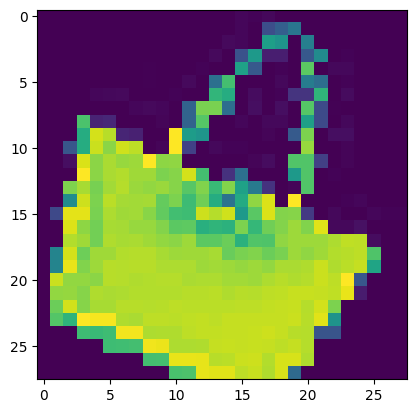

In [16]:
trainer1.mnist_random_example()

In [14]:
trainer1.train_loop(50)
trainer2.train_loop(50)
trainer3.train_loop(50)

100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


{'train_loss': [1.0653109550476074,
  1.0647053718566895,
  1.0641021728515625,
  1.0635021924972534,
  1.0629045963287354,
  1.0623083114624023,
  1.0617159605026245,
  1.0611261129379272,
  1.0605385303497314,
  1.0599534511566162,
  1.0593703985214233,
  1.0587892532348633,
  1.0582096576690674,
  1.0576313734054565,
  1.0570557117462158,
  1.0564817190170288,
  1.0559091567993164,
  1.0553383827209473,
  1.05476975440979,
  1.054202914237976,
  1.0536378622055054,
  1.0530747175216675,
  1.052513837814331,
  1.051953911781311,
  1.0513957738876343,
  1.050839900970459,
  1.0502856969833374,
  1.0497338771820068,
  1.04918372631073,
  1.0486350059509277,
  1.0480881929397583,
  1.0475431680679321,
  1.0470008850097656,
  1.0464609861373901,
  1.0459227561950684,
  1.0453869104385376,
  1.044853925704956,
  1.0443227291107178,
  1.043792963027954,
  1.043264627456665,
  1.0427385568618774,
  1.0422136783599854,
  1.0416898727416992,
  1.041167974472046,
  1.0406473875045776,
  1.0401

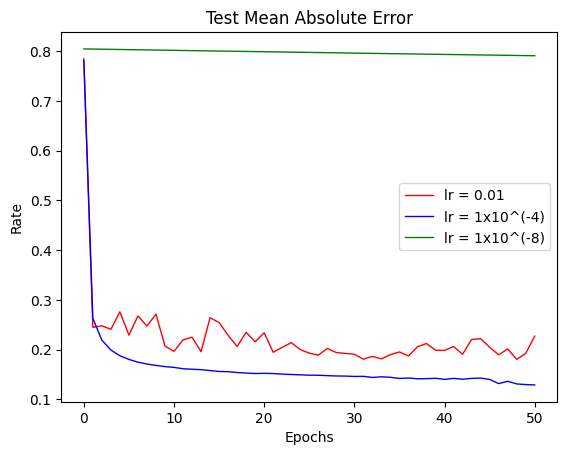

In [15]:
label_to_string = {
    'train_loss': "Perte points d'entraînement",
    'train_mae': "MAE des points d'entraînement",
    'test_loss': 'Perte points de test',
    'test_mae': "Test Mean Absolute Error",
}

trainers = [trainer1,trainer2,trainer3]
y = [trainer.train_logs["test_mae"] for trainer in trainers]
x = range(51)


plt.plot(x, y[0], marker='', color='red', linewidth=1, label="lr = 0.01")
plt.plot(x, y[1], marker='', color='blue', linewidth=1, label="lr = 1x10^(-4)")
plt.plot(x, y[2], marker='', color='green', linewidth=1, label="lr = 1x10^(-8)")
plt.title(label_to_string["test_mae"])
plt.xlabel("Epochs")
plt.ylabel("Rate")
plt.legend()
plt.show()

# CNN

In [10]:
cnn = Trainer(network_type="cnn")

In [11]:
cnn.train_loop(50)

100%|██████████| 50/50 [21:07<00:00, 25.35s/it]


{'train_loss': [1.0252031087875366,
  0.19630180299282074,
  0.1414628028869629,
  0.11182331293821335,
  0.09822044521570206,
  0.08667238801717758,
  0.0748601034283638,
  0.07502604275941849,
  0.060147807002067566,
  0.0619935542345047,
  0.05498984083533287,
  0.050697967410087585,
  0.04867631196975708,
  0.04653211310505867,
  0.0525103323161602,
  0.037629757076501846,
  0.036319442093372345,
  0.03378693386912346,
  0.03414059802889824,
  0.033667996525764465,
  0.03153890743851662,
  0.028652464970946312,
  0.028274867683649063,
  0.034915000200271606,
  0.03647144138813019,
  0.031626079231500626,
  0.021774159744381905,
  0.0187572930008173,
  0.018369920551776886,
  0.012450983747839928,
  0.009633665904402733,
  0.03590211644768715,
  0.010934912599623203,
  0.009812426753342152,
  0.009551272727549076,
  0.008160804398357868,
  0.006778418086469173,
  0.006155604030936956,
  0.00664868438616395,
  0.047421082854270935,
  0.018568765372037888,
  0.009099739603698254,
  0.

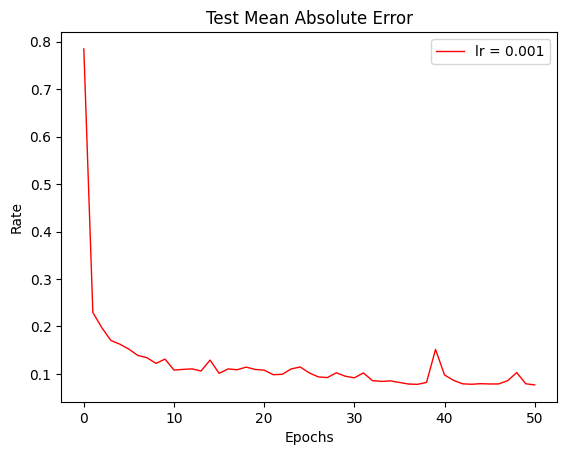

In [12]:
label_to_string = {
    'train_loss': "Perte points d'entraînement",
    'train_mae': "MAE des points d'entraînement",
    'test_loss': 'Perte points de test',
    'test_mae': "Test Mean Absolute Error",
}

y = cnn.train_logs["test_mae"]
x = range(51)


plt.plot(x, y, marker='', color='red', linewidth=1, label="lr = 0.001")
plt.title(label_to_string["test_mae"])
plt.xlabel("Epochs")
plt.ylabel("Rate")
plt.legend()
plt.show()